In [1]:
import pandas as pd

df = pd.read_csv('data/twitter-hate-speech.csv', index_col=0)

In [2]:
df.head(n=10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [7]:
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, strip_punctuation, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from gensim.corpora import Dictionary
import re

RE_USERNAME = re.compile(r'@[a-z_]+', re.UNICODE)

def strip_usernames(s):
    return RE_USERNAME.sub('', s)

MY_FILTERS = [
    lambda x: x.lower(), strip_usernames, strip_punctuation, 
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short
]

preprocessed = [preprocess_string(s, MY_FILTERS) for s in df['tweet']]

dictionary = Dictionary(preprocessed)
dictionary.filter_extremes(no_below=5, no_above=0.2)

sequences = [dictionary.doc2idx(x, unknown_word_index=0) for x in preprocessed]

MAXLEN = 20

#padded = pad_sequences(sequences, MAXLEN, padding='post', truncating='post')
padded = pad_sequences(sequences, MAXLEN)

N_CLASS = 3
HATE = 2
OFFENSIVE = 1
NEUTRAL = 0

def determine_label(row):
    if row['hate_speech'] >= row['offensive_language'] and row['hate_speech'] > row['neither']:
        return HATE
    elif row['offensive_language'] >= row['hate_speech'] and row['offensive_language'] > row['neither']:
        return OFFENSIVE
    else:
        return NEUTRAL

labels = df.apply(determine_label, axis=1)

X = padded
y = to_categorical(labels, num_classes=N_CLASS)

In [8]:
preprocessed[:5]

[['woman', 'shouldn', 'complain', 'cleaning', 'house', 'amp', 'man', 'trash'],
 ['boy',
  'dats',
  'cold',
  'tyga',
  'dwn',
  'bad',
  'cuffin',
  'dat',
  'hoe',
  'place'],
 ['dawg', 'sbabylife', 'fuck', 'bitch', 'start', 'confused', 'shit'],
 ['look', 'like', 'tranny'],
 ['shit', 'hear', 'true', 'faker', 'bitch', 'told']]

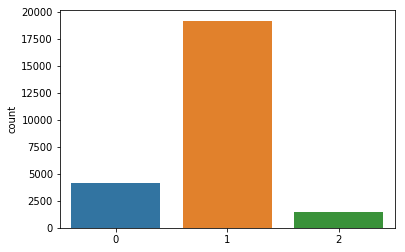

In [9]:
%matplotlib inline
import seaborn as sns

sns.countplot(labels)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

def build_lstm_model():
    model = Sequential()
    model.add(Embedding(len(dictionary), 20, input_length=MAXLEN))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASS, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [64]:
from sklearn.utils.class_weight import compute_class_weight

compute_class_weight('balanced', (NEUTRAL, OFFENSIVE, HATE), labels)

array([1.98438626, 0.43048463, 5.77692308])

In [65]:
model = build_lstm_model()

history = model.fit(X_train, y_train, batch_size=1000, epochs=20, validation_data=(X_test, y_test),
                    class_weight={0:5, 1:1, 2:20}, verbose=0)

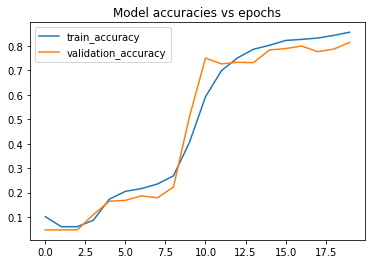

In [66]:
import pandas as pd
%matplotlib inline

df = pd.DataFrame({
    'train_accuracy': history.history['acc'],
    'validation_accuracy': history.history['val_acc'],
})

df.plot(title='Model accuracies vs epochs')

In [67]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
                            target_names=('Neutral', 'Offensive', 'Hate')))

             precision    recall  f1-score   support

    Neutral       0.70      0.85      0.77       795
  Offensive       0.95      0.82      0.88      3928
       Hate       0.21      0.53      0.30       234

avg / total       0.87      0.81      0.84      4957

